## 1. Install / Import Required Libraries


In [1]:
!pip install sdv
!pip install table_evaluator
!pip install pycaret
!pip install pandas
!pip install fairlearn
!pip install shap

In [2]:
# Core data & SDV
import pandas as pd
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality

# Visualization & custom evaluation
from table_evaluator import TableEvaluator

# Classification & AutoML
from pycaret.classification import setup, compare_models, plot_model

# Fairness metrics
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)

# Modeling / utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Constants
SEED = 123
DISCRETE_COLUMNS = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']


## 2. Load & Inspect Real Data


In [3]:
# Load the real dataset
real_data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Quick overview
real_data.info()
real_data.head()
real_data.columns.tolist()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'high_blood_pressure',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'DEATH_EVENT']

## 3. Create SDV Metadata & Synthesizer


In [4]:
# Build metadata from real data
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data)

# Configure and instantiate the TVAE synthesizer
synthesizer = TVAESynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=500,
    verbose=False,
    cuda=True,        # assumes a GPU is available
)


## 4. Fit Synthesizer & Generate Synthetic Data


In [5]:
# Train the synthesizer
synthesizer.fit(real_data)

# Sample synthetic data
synthetic_data = synthesizer.sample(num_rows=real_data.shape[0] - 1)
synthetic_data.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,58.168643,0,702,0,45,0,260841.225065,0.976930,136,1,0,206,0
1,63.397484,0,86,0,39,0,132322.091379,0.923141,136,1,1,224,0
2,73.101207,0,23,0,38,1,374589.332861,1.128083,134,0,0,79,0
3,68.843994,1,106,0,60,0,205979.602908,0.974682,143,1,0,59,1
4,63.910423,1,238,1,69,0,183139.648264,1.195566,141,0,0,240,0


## 5. Quantitative & Visual Quality Evaluation


In [6]:
# Quantitative quality report
quality_report = evaluate_quality(real_data, synthetic_data, metadata)
print(quality_report)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 13/13 [00:00<00:00, 3559.60it/s]|
Column Shapes Score: 85.3%

(2/2) Evaluating Column Pair Trends: |██████████| 78/78 [00:00<00:00, 716.66it/s]|
Column Pair Trends Score: 71.13%

Overall Score (Average): 78.21%



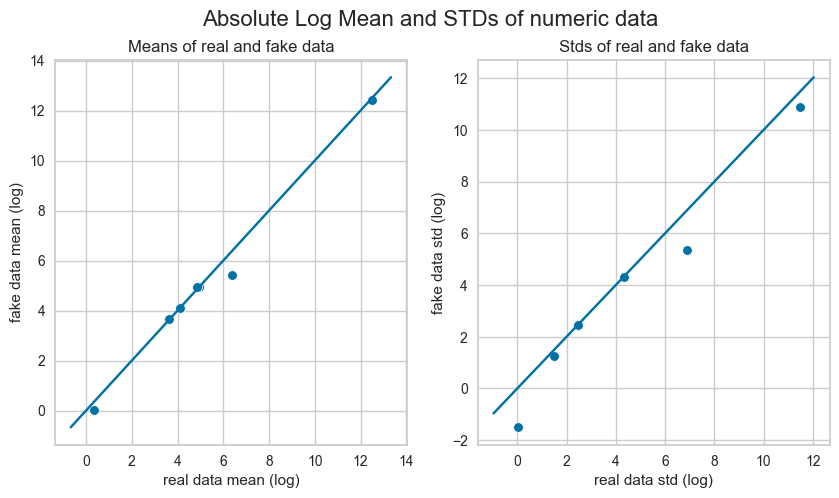

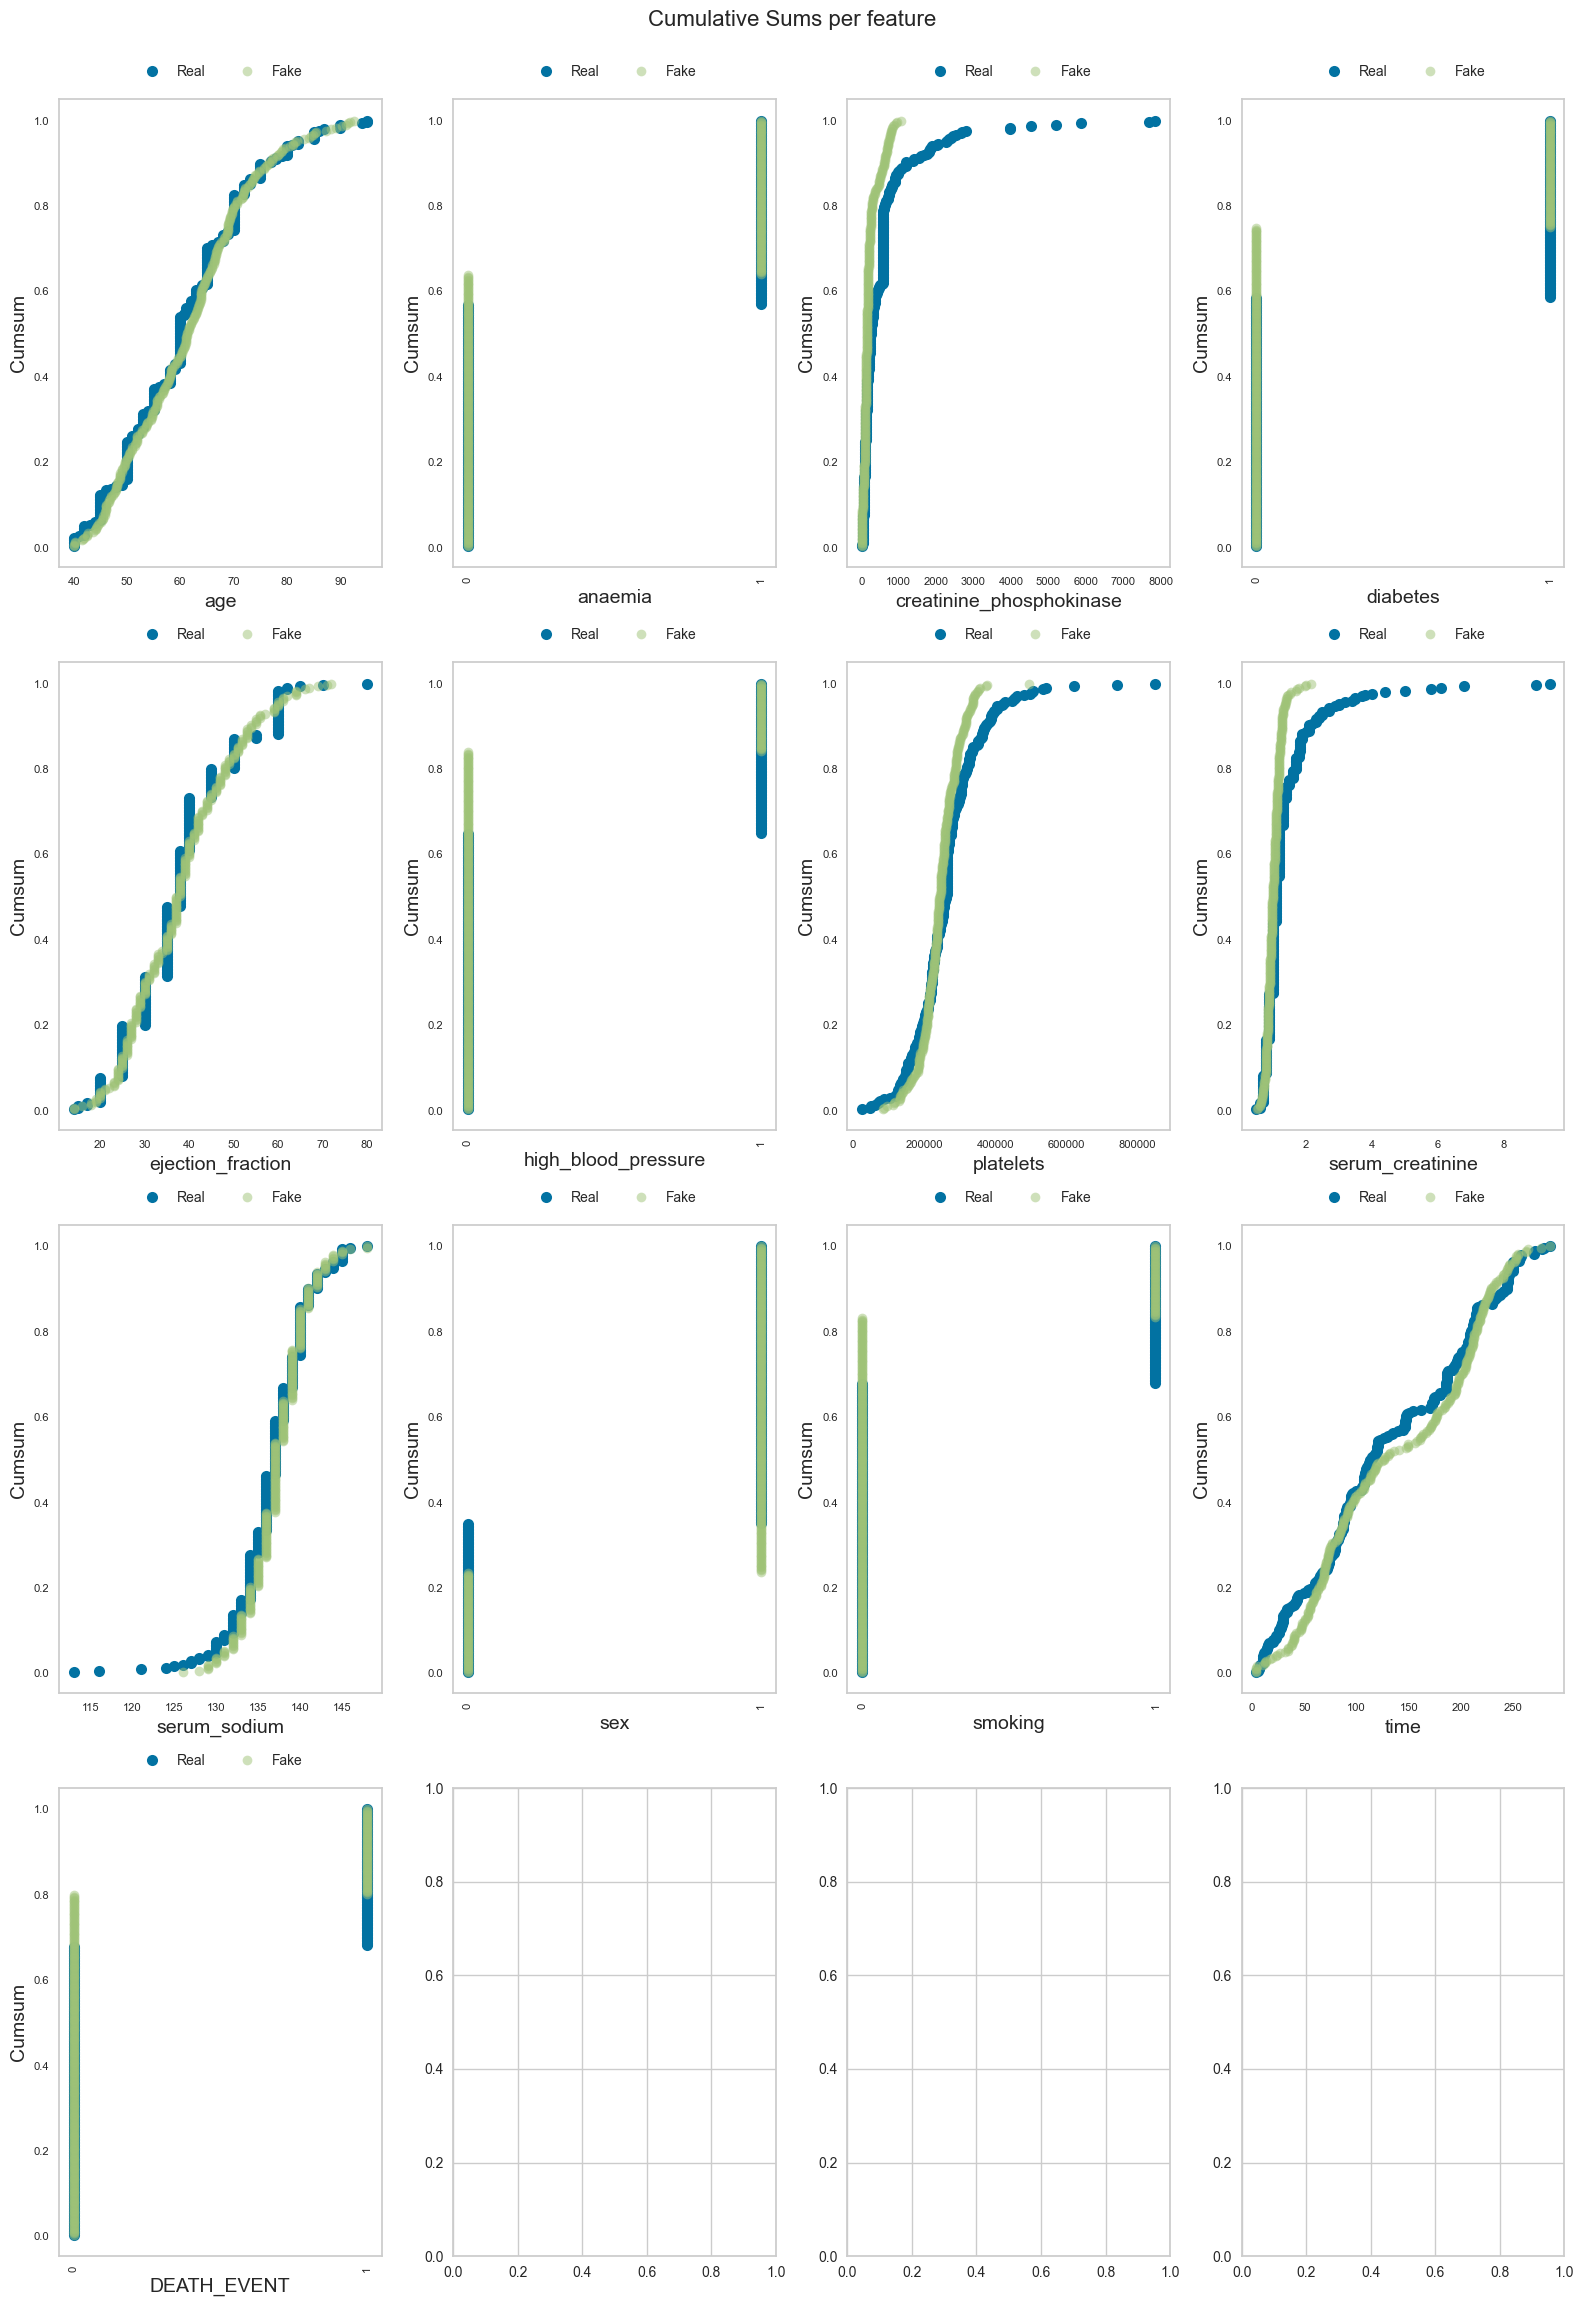

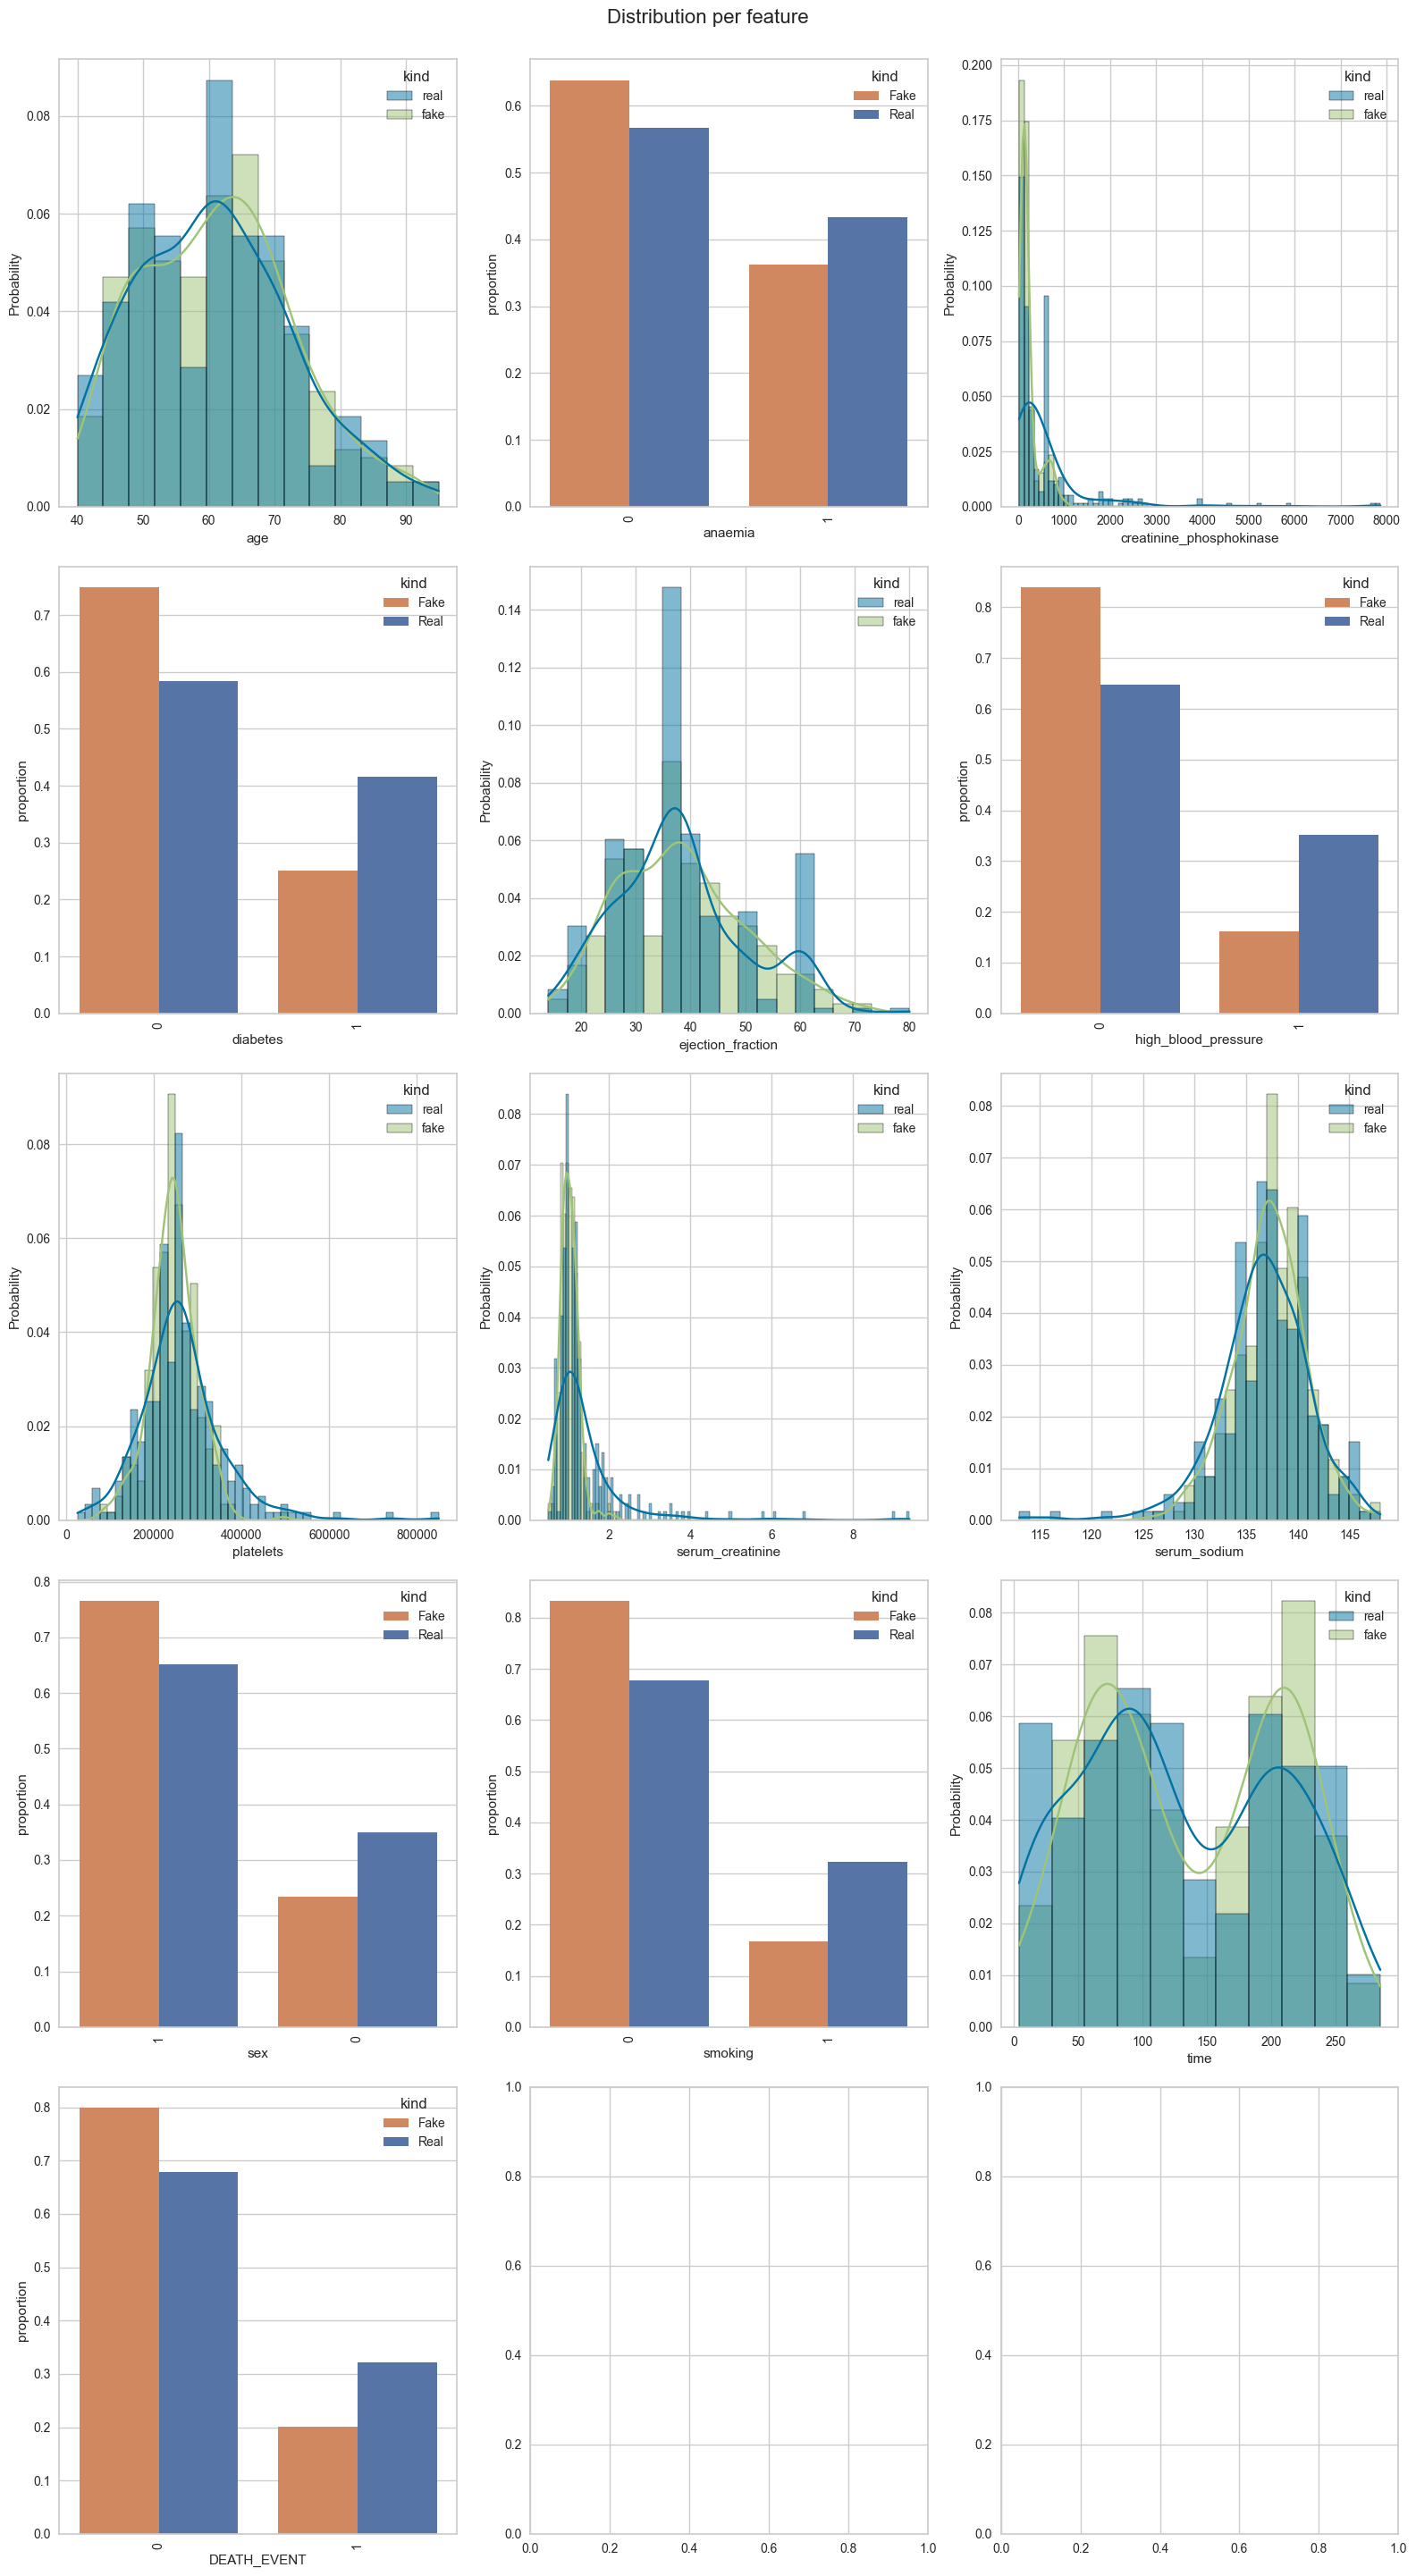

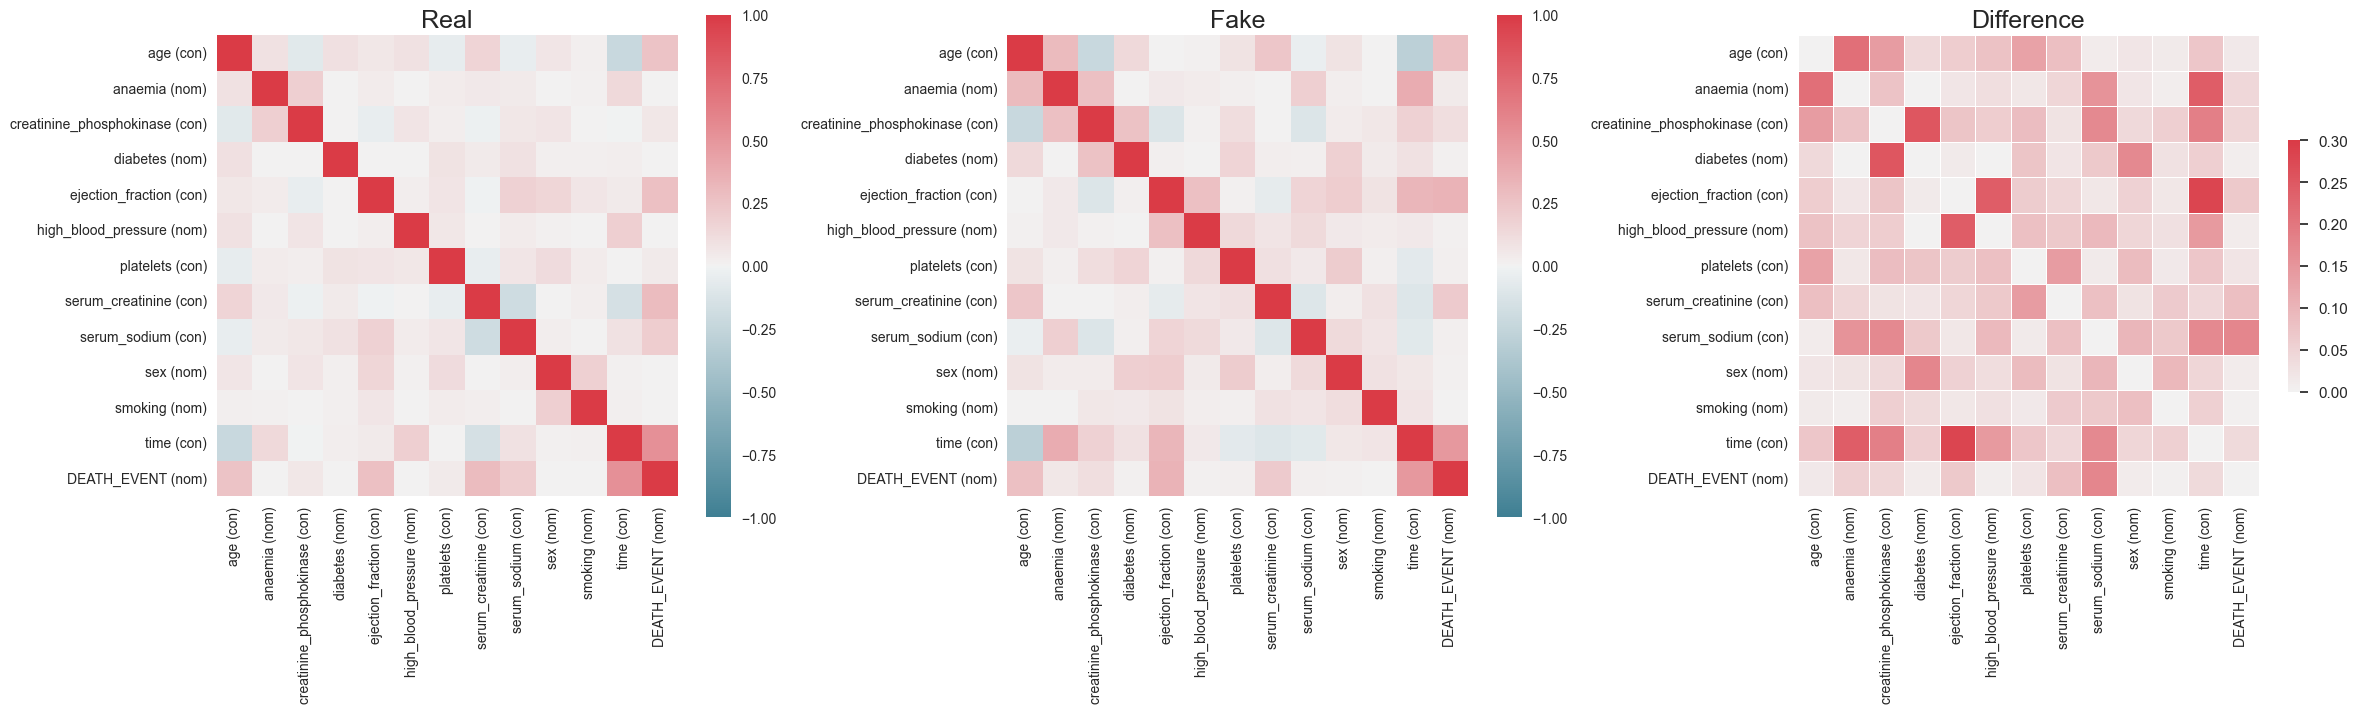

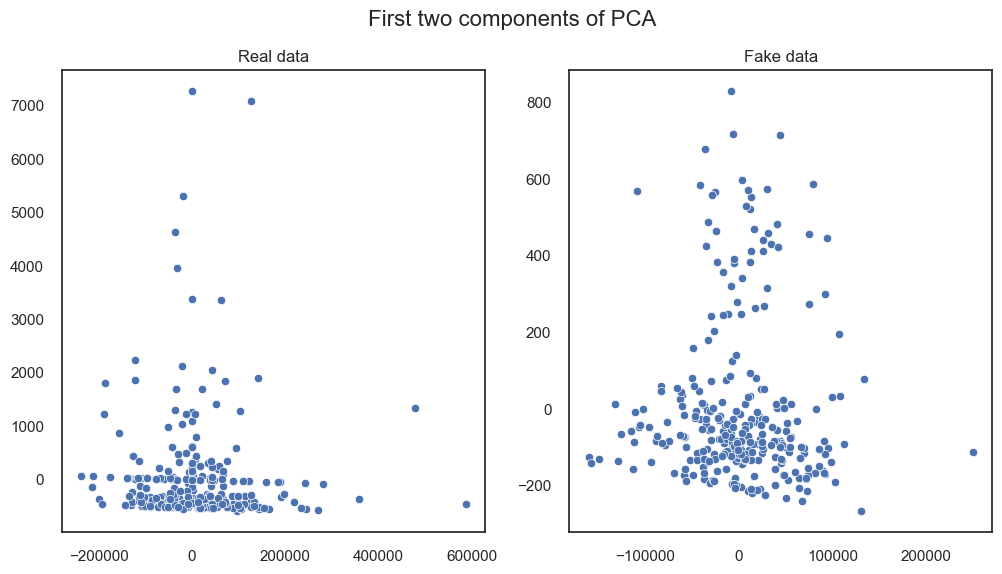

In [7]:
# Visual diagnostics
table_evaluator = TableEvaluator(real_data, synthetic_data, cat_cols=DISCRETE_COLUMNS)
table_evaluator.visual_evaluation()

## 6. Compare Classification on Synthetic vs. Real


,Description,Value
0,Session id,123
1,Target,DEATH_EVENT
2,Target type,Binary
3,Original data shape,"(597, 13)"
4,Transformed data shape,"(597, 13)"
5,Transformed train set shape,"(298, 13)"
6,Transformed test set shape,"(299, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8359,0.8822,0.4833,0.6371,0.5385,0.4427,0.4550,0.0380
ridge,Ridge Classifier,0.8357,0.8739,0.3333,0.6883,0.4235,0.3525,0.3962,0.0080
et,Extra Trees Classifier,0.8355,0.8890,0.3667,0.7421,0.4549,0.3758,0.4229,0.0420
gbc,Gradient Boosting Classifier,0.8328,0.8725,0.5000,0.6773,0.5468,0.4493,0.4727,0.0590
lda,Linear Discriminant Analysis,0.8289,0.8759,0.4500,0.6717,0.5043,0.4094,0.4371,0.0080
ada,Ada Boost Classifier,0.8257,0.8537,0.6000,0.6459,0.5688,0.4691,0.4978,0.0390
rf,Random Forest Classifier,0.8191,0.8835,0.3833,0.6405,0.4484,0.3522,0.3829,0.0560
lightgbm,Light Gradient Boosting Machine,0.8191,0.8729,0.4500,0.6350,0.4870,0.3873,0.4142,0.3560
qda,Quadratic Discriminant Analysis,0.8055,0.8409,0.5667,0.5305,0.5352,0.4152,0.4232,0.0080
nb,Naive Bayes,0.8051,0.8628,0.6667,0.5139,0.5700,0.4496,0.4627,0.0080


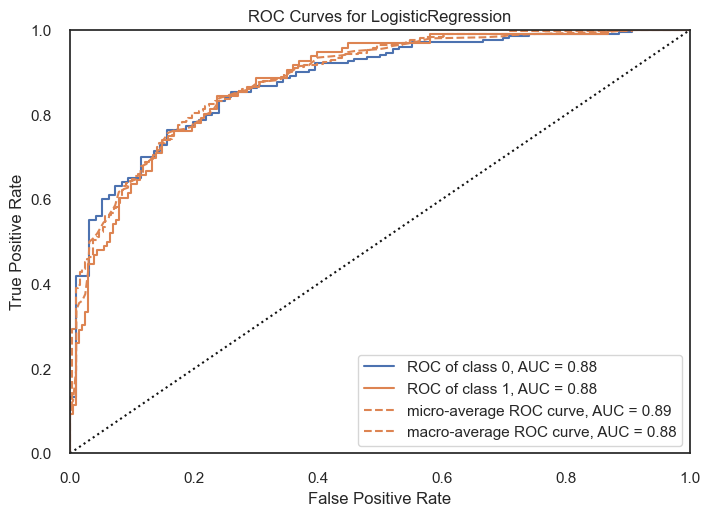

In [8]:
# 6.1 Setup PyCaret on synthetic data
synth_setup = setup(
    data=synthetic_data,
    target='DEATH_EVENT',
    test_data=real_data,
    session_id=SEED,
    n_jobs = None,
    index=False
)
best_synth_model = compare_models()
plot_model(best_synth_model, plot='auc')

,Description,Value
0,Session id,123
1,Target,DEATH_EVENT
2,Target type,Binary
3,Original data shape,"(299, 13)"
4,Transformed data shape,"(299, 13)"
5,Transformed train set shape,"(209, 13)"
6,Transformed test set shape,"(90, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8181,0.9241,0.6595,0.7976,0.6804,0.5635,0.5916,0.0450
et,Extra Trees Classifier,0.8088,0.8875,0.5548,0.8342,0.6383,0.5214,0.5524,0.0390
lightgbm,Light Gradient Boosting Machine,0.8040,0.8649,0.6119,0.7621,0.6562,0.5247,0.5465,0.2240
gbc,Gradient Boosting Classifier,0.7990,0.8702,0.6143,0.7835,0.6444,0.5138,0.5482,0.0430
lr,Logistic Regression,0.7855,0.8813,0.6167,0.7429,0.6441,0.4973,0.5213,0.0290
lda,Linear Discriminant Analysis,0.7855,0.8719,0.6310,0.7076,0.6519,0.5013,0.5137,0.0060
nb,Naive Bayes,0.7805,0.8355,0.4976,0.7083,0.5642,0.4393,0.4596,0.0070
ada,Ada Boost Classifier,0.7802,0.8264,0.5833,0.7251,0.6302,0.4778,0.4938,0.0350
ridge,Ridge Classifier,0.7712,0.8729,0.5857,0.6976,0.6190,0.4608,0.4771,0.0070
dt,Decision Tree Classifier,0.7557,0.7236,0.6381,0.6218,0.6204,0.4417,0.4499,0.0070


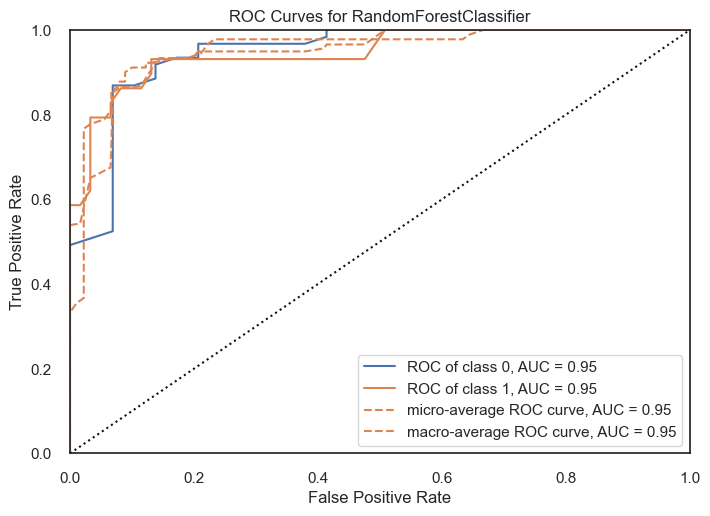

In [9]:
# 6.2 Setup PyCaret on real data
real_setup = setup(
    data=real_data,
    target='DEATH_EVENT',
    session_id=SEED,
    n_jobs = None,
    index=False
)
best_real_model = compare_models()
plot_model(best_real_model, plot='auc')

## 7. Fairness Analysis on Synthetic Data


In [10]:
# Prepare features and protected attributes
y       = synthetic_data['DEATH_EVENT']
A_sex   = synthetic_data['sex']
median_age = synthetic_data['age'].median()
A_age   = (synthetic_data['age'] < median_age).astype(int)

X = synthetic_data.drop(columns=['DEATH_EVENT'])

# Train/test split (stratify on label)
X_tr, X_te, y_tr, y_te, sex_tr, sex_te, age_tr, age_te = train_test_split(
    X, y, A_sex, A_age,
    stratify=y,
    test_size=0.3,
    random_state=SEED
)

# Train a logistic regression
clf_syn = LogisticRegression(max_iter=1_000)
clf_syn.fit(X_tr, y_tr)
y_pred = clf_syn.predict(X_te)

# Compute group metrics by sex
mf_sex = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=y_te,
    y_pred=y_pred,
    sensitive_features=sex_te
)

print("=== Group metrics by sex ===")
print(mf_sex.by_group)

# Statistical parity difference & equalized odds difference
spd_sex = demographic_parity_difference(y_te, y_pred, sensitive_features=sex_te)
eod_sex = equalized_odds_difference(y_te, y_pred, sensitive_features=sex_te)
print(f"\nStatistical Parity Difference (sex): {spd_sex:.3f}")
print(f"Equalized Odds Difference (sex):   {eod_sex:.3f}")

# --- Group metrics by age on synthetic data ---
mf_age = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=y_te,
    y_pred=y_pred,
    sensitive_features=age_te
)

print("=== Group metrics by age (young=1 / old=0) ===")
print(mf_age.by_group)

# --- Statistical parity & equalized odds for age on synthetic data ---
spd_age = demographic_parity_difference(y_te, y_pred, sensitive_features=age_te)
eod_age = equalized_odds_difference(y_te, y_pred, sensitive_features=age_te)
print(f"\nStatistical Parity Difference (age): {spd_age:.3f}")
print(f"Equalized Odds Difference   (age): {eod_age:.3f}")

=== Group metrics by sex ===
     accuracy       fpr       fnr
sex                              
0    0.736842  0.071429  0.800000
1    0.830986  0.120690  0.384615

Statistical Parity Difference (sex): 0.106
Equalized Odds Difference (sex):   0.415
=== Group metrics by age (young=1 / old=0) ===
     accuracy       fpr  fnr
age                         
0       0.760  0.171429  0.4
1       0.875  0.054054  1.0

Statistical Parity Difference (age): 0.250
Equalized Odds Difference   (age): 0.600


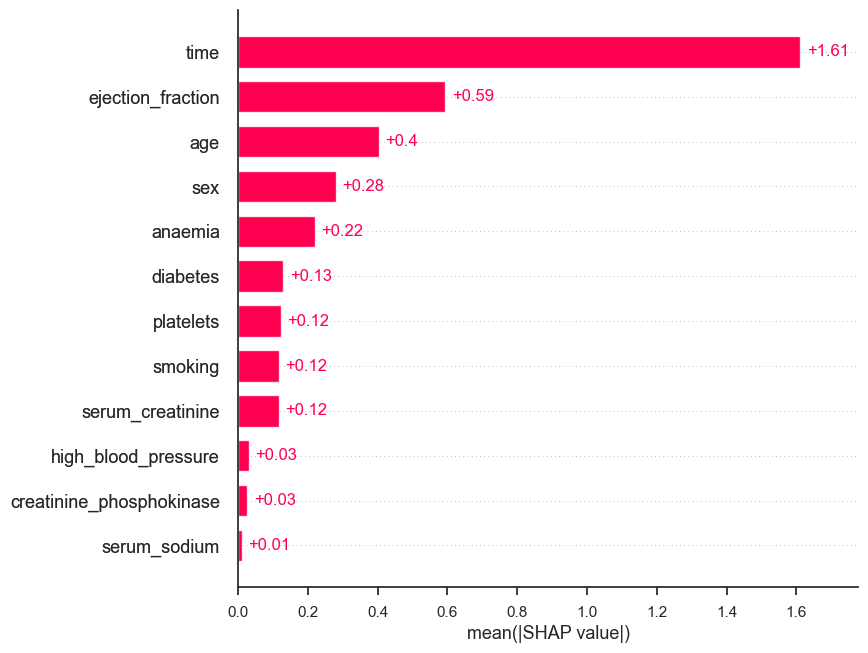

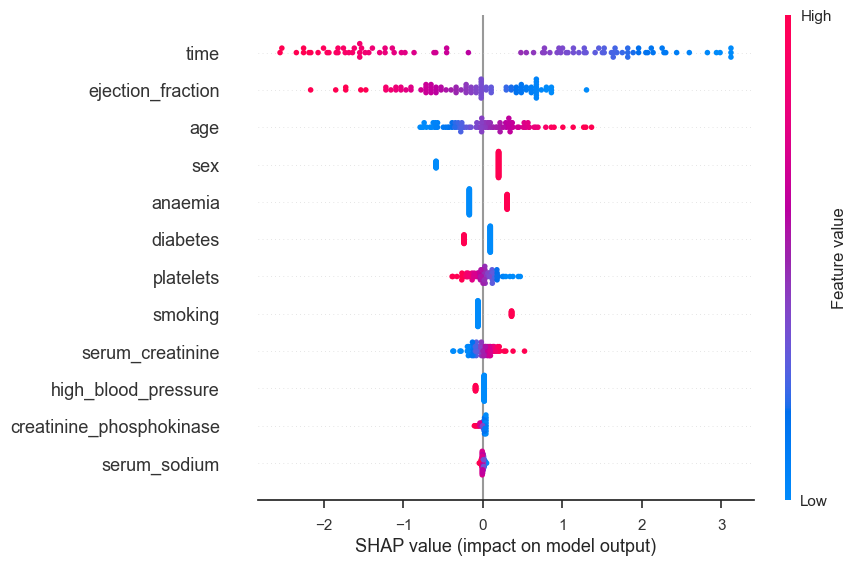

In [11]:
# ---------------------------------------------------------
# ❶  SHAP ANALYSIS – Synthetic-data model
# ---------------------------------------------------------
import shap
from pathlib import Path

# (a) Build an explainer  – exact for linear models
expl_syn = shap.Explainer(clf_syn, X_tr, feature_names=X_tr.columns)

# (b) Compute Shapley values for the *test* split
shap_vals_syn = expl_syn(X_te)

# (c) Global importance – bar plot
shap.plots.bar(shap_vals_syn, max_display=15, show=True)

# (d) Summary dot-plot (beeswarm)
shap.plots.beeswarm(shap_vals_syn, max_display=15, show=True)

# (e) Store results so they survive the notebook kernel
Path("outputs").mkdir(exist_ok=True)

## 8. Fairness Analysis on Real Data


In [12]:
# --- Prepare the real‐data features and protected attributes ---
y_real    = real_data['DEATH_EVENT']
A_sex_real = real_data['sex']
median_age_real = real_data['age'].median()
A_age_real  = (real_data['age'] < median_age_real).astype(int)

X_real = real_data.drop(columns=['DEATH_EVENT'])

# --- Split into train/test (stratified by the label) ---
Xr_tr, Xr_te, yr_tr, yr_te, sexr_tr, sexr_te, ager_tr, ager_te = train_test_split(
    X_real, y_real, A_sex_real, A_age_real,
    stratify=y_real,
    test_size=0.3,
    random_state=SEED
)

# --- Train a baseline classifier on real data ---
clf_real = LogisticRegression(max_iter=1000)
clf_real.fit(Xr_tr, yr_tr)
yr_pred = clf_real.predict(Xr_te)

# --- Group metrics by sex on real data ---
mf_real_sex = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=yr_te,
    y_pred=yr_pred,
    sensitive_features=sexr_te
)

print("=== Real Data: Group metrics by sex ===")
print(mf_real_sex.by_group)

# --- Statistical parity & equalized odds for sex on real data ---
spd_real_sex = demographic_parity_difference(yr_te, yr_pred, sensitive_features=sexr_te)
eod_real_sex = equalized_odds_difference(yr_te, yr_pred, sensitive_features=sexr_te)
print(f"\nStatistical Parity Difference (sex, real): {spd_real_sex:.3f}")
print(f"Equalized Odds Difference   (sex, real): {eod_real_sex:.3f}")

# --- (Optional) Repeat fairness for age groups on real data ---
mf_real_age = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=yr_te,
    y_pred=yr_pred,
    sensitive_features=ager_te
)

print("\n=== Real Data: Group metrics by age (young=1 / old=0) ===")
print(mf_real_age.by_group)

spd_real_age = demographic_parity_difference(yr_te, yr_pred, sensitive_features=ager_te)
eod_real_age = equalized_odds_difference(yr_te, yr_pred, sensitive_features=ager_te)
print(f"\nStatistical Parity Difference (age, real): {spd_real_age:.3f}")
print(f"Equalized Odds Difference   (age, real): {eod_real_age:.3f}")


=== Real Data: Group metrics by sex ===
     accuracy       fpr       fnr
sex                              
0     0.78125  0.052632  0.461538
1     0.87931  0.047619  0.312500

Statistical Parity Difference (sex, real): 0.026
Equalized Odds Difference   (sex, real): 0.149

=== Real Data: Group metrics by age (young=1 / old=0) ===
     accuracy       fpr       fnr
age                              
0    0.821429  0.058824  0.363636
1    0.882353  0.037037  0.428571

Statistical Parity Difference (age, real): 0.139
Equalized Odds Difference   (age, real): 0.065


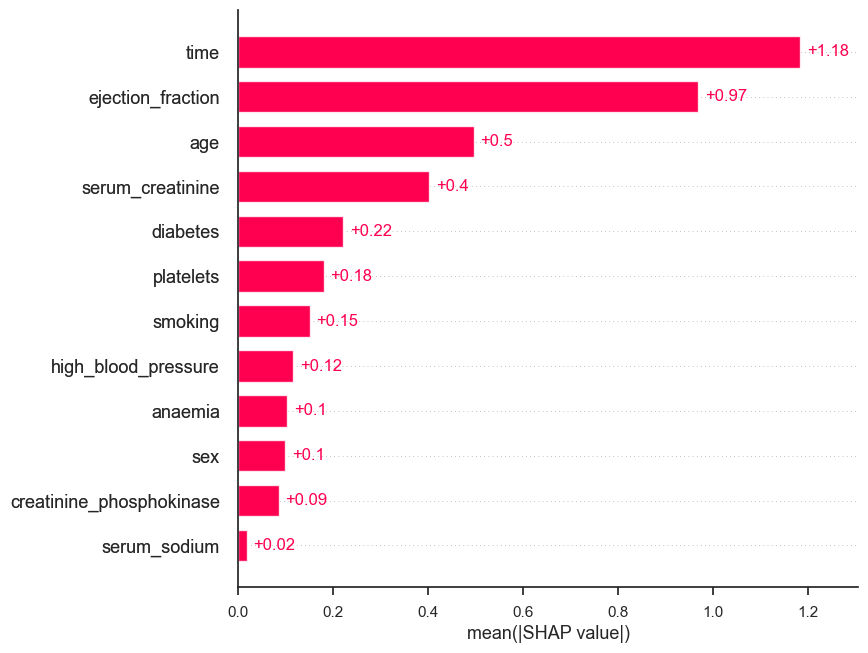

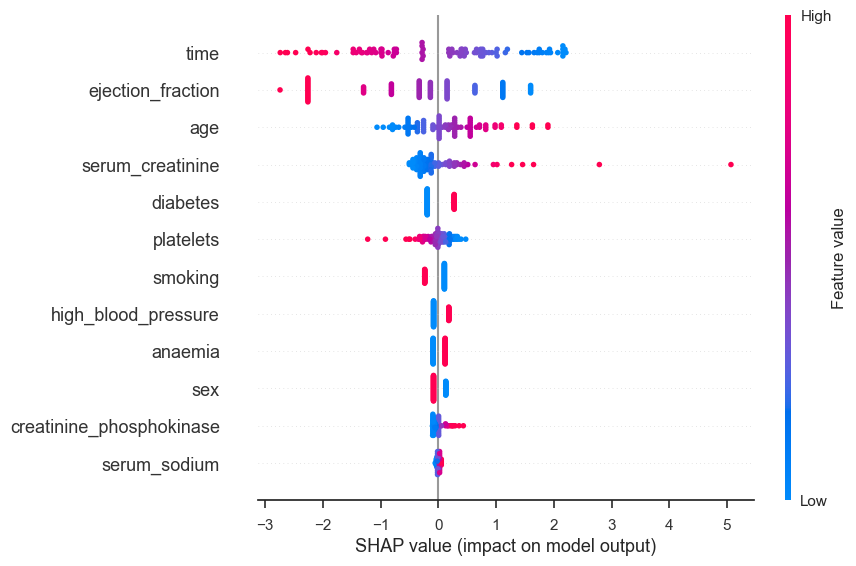

In [13]:
# ---------------------------------------------------------
# ❷  SHAP ANALYSIS – Real-data model
# ---------------------------------------------------------
expl_real = shap.Explainer(clf_real, Xr_tr, feature_names=Xr_tr.columns)
shap_vals_real = expl_real(Xr_te)

shap.plots.bar(shap_vals_real, max_display=15, show=True)
shap.plots.beeswarm(shap_vals_real, max_display=15, show=True)
